# Evolving sentiment in Crypto markets
James Rockey (jrockey2)

Kareem Benaissa (kareem2)

### This project explores the relationship between cryptocurrency sentiment through tweets

This is done in the following steps:

1. Calculate sentiment of tweets with BERT model pretrained with financial sentiment

Model: https://huggingface.co/ProsusAI/finbert

Tweets dataset: https://www.kaggle.com/code/codeblogger/bitcoin-sentiment-analysis

Tweets are preprocessed before they are fed into the model.

The FinBERT model outputs percentage confidence in three following sentiment categories: ['positive', 'negative', 'neutral']

2. After sentiment scores are calculated for every tweet, we compare the effect of sentiment on predictive power of LSTMs. 

For the purposes of this research we want to explore intraday sentiment. So, we collected tweets from 15 random days in February 2021 and March 2021, and for each of these days we calculated sentiment in 10 minute increments. We then considered different sized sequences of 10 minutes to predict the next 1 or 2 sequences. We compare LSTM's prediction of price, volume, and other features, using these features as a baseline, with its performance when sentiment and weighted average sentiment are included in trainging.

## Step 1: Calculating Sentiment

In our dataset, the 'text' column contains the content of the tweet. We preprocess this text and use our BERT model to calculate sentiment

In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request




/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df = pd.read_csv('datasets/Bitcoin_tweets.csv', sep=',', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48583 entries, 0 to 48582
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         48582 non-null  object
 1   user_location     28273 non-null  object
 2   user_description  45263 non-null  object
 3   user_created      48583 non-null  object
 4   user_followers    48583 non-null  int64 
 5   user_friends      48583 non-null  int64 
 6   user_favourites   48583 non-null  int64 
 7   user_verified     48583 non-null  bool  
 8   date              48583 non-null  object
 9   text              48583 non-null  object
 10  hashtags          38416 non-null  object
 11  source            47685 non-null  object
 12  is_retweet        48583 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 4.2+ MB


In [10]:
# Load the model
MODEL = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [11]:
# helper functions
def get_labels(): 
    labels=[]

    # This is for another BERT model that we tried:
    # mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    # with urllib.request.urlopen(mapping_link) as f:
    #     html = f.read().decode('utf-8').split("\n")
    #     csvreader = csv.reader(html, delimiter='\t')
    # labels = [row[1] for row in csvreader if len(row) > 1]

    # This is for the FinBERT model:
    labels = ['positive', 'negative', 'neutral']
    return labels


def preprocess(text):
    '''
    Preprocess text (username and link placeholders)
    '''    
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


def process_tweet(text: str):
    '''
    Calculates sentiment scores for the given text
    '''
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

# Modified print_scores function to return values instead of printing
def get_sentiment_scores(scores):
    labels = get_labels()
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return {labels[ranking[i]]: np.round(float(scores[ranking[i]]), 4) for i in range(scores.shape[0])}

# Function to apply to each row
def analyze_sentiment(row):
    '''
    Takes in row from dataframe and returns a series of sentiment scores
    Used in df.apply()
    '''
    text = row['text']
    scores = process_tweet(text)
    labels = get_labels()
    sentiment_scores = get_sentiment_scores(scores, labels)
    print(pd.Series([sentiment_scores.get('positive', 0), 
                      sentiment_scores.get('neutral', 0), 
                      sentiment_scores.get('negative', 0)]))
    return pd.Series([sentiment_scores.get('positive', 0), 
                      sentiment_scores.get('neutral', 0), 
                      sentiment_scores.get('negative', 0)])

def print_scores(scores, labels):
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")


### Example use of sentiment model

In [33]:
text = '''I'm absolutely ecstatic about Bitcoin's remarkable 
performance and incredibly optimistic about its
 potential to revolutionize finance''' # example tweet

scores = process_tweet(text)
labels = get_labels()
print_scores(scores, labels)

1) positive 0.9032
2) neutral 0.0864
3) negative 0.0103


### Apply to dataset
Note, this may take several hours. Data with sentiment scores already calculated is found in this file: sentiment_added_data.csv

In [34]:
# df[['positive', 'neutral', 'negative']] = df.apply(analyze_sentiment, axis=1)
# df.to_csv('sentiment_added_data.csv')



# ____________________________________________________________________________
# Step 2: Analyzing Sentiment

Here, we explore how sentiment using the bert model effects LSTM prediction

### Calculate 10 minute sentiment scores for each day in dataset

The sentiment score for a given day is found by taking an average of the ['positive', 'negative', 'neutral'] columns in our dataset during a 10-mintue interval. 

For each trading day, we group tweets into 10-minute intervals starting at 12:00:00 am until 11:59:59 pm. 

We also explore how the "reach" of a tweet affects daily sentiment by calculating a weighted average over the number of followers twitter user.

If a 10-minute slice is missing tweets, we give each column equal weight

In [147]:
'''
The following functions calculate the weighted average 
and average sentiment scores for a group from the dataframe.

Input: group: from the df.groupby() function

Output: series of weighted average and average sentiment scores

'''

def weighted_average(group):
    weighted_positive = (group['positive'] * group['user_followers']).sum()
    weighted_neutral = (group['neutral'] * group['user_followers']).sum()
    weighted_negative = (group['negative'] * group['user_followers']).sum()
    total_followers = np.sum(group['user_followers'])
    
    if total_followers == 0:
        return pd.Series({
            'weighted_avg_positive': 1/3,
            'weighted_avg_neutral': 1/3,
            'weighted_avg_negative': 1/3
        })
    return pd.Series({
        'weighted_avg_positive': weighted_positive / total_followers,
        'weighted_avg_neutral': weighted_neutral / total_followers,
        'weighted_avg_negative': weighted_negative / total_followers
    })

def average(group):
    avg_positive = group['positive'].mean()
    avg_neutral = group['neutral'].mean()
    avg_negative = group['negative'].mean()

    total_followers = np.sum(group['user_followers'])
    
    if total_followers == 0:
        # print('INVALID TOTAL' + str(count))
        return pd.Series({
            'weighted_avg_positive': 1/3,
            'weighted_avg_neutral': 1/3,
            'weighted_avg_negative': 1/3
        })
    return pd.Series({
        'avg_positive': avg_positive,
        'avg_neutral': avg_neutral,
        'avg_negative': avg_negative
    })


### Group Data into 10 minute intervals

In [148]:
'''
This function takes in a dataframe for a single day 
and returns dataframe filtered into 10 minute sentiment intervals by the date
'''
def process_day_data(day_df, interval_size='10T', default_values=None):

    day_df['date'] = pd.to_datetime(day_df['date'])

    day_date = day_df['date'].dt.date.iloc[0]

    start_time = pd.to_datetime(f"{day_date} 00:00:00")
    end_time = pd.to_datetime(f"{day_date} 23:59:59")
    date_range = pd.date_range(start=start_time, end=end_time, freq=interval_size)

    # Change weighted average to average if needed
    grouped_data = day_df.groupby(pd.Grouper(key='date', freq=interval_size)).apply(average).reset_index()


    grouped_data.set_index('date', inplace=True)

    grouped_data = grouped_data.reindex(date_range)

    # Set default values for missing data
    default_values = default_values or 1/3
    grouped_data.fillna(default_values, inplace=True)

    # Reset index to make it a column again, if needed
    grouped_data.reset_index(inplace=True, drop=False)
    grouped_data.rename(columns={'index': 'date'}, inplace=True)

    return grouped_data

### Twitter sentiment grouped into days, and then into 10 minute intervals

Reformat data and fill in for any gaps in sentiment score with average value

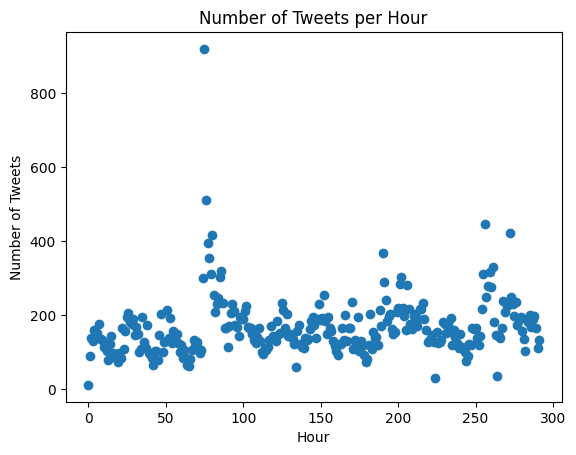

292


In [228]:
sentiment_df = pd.read_csv('datasets/refactored_sentiment_added_data_and_date.csv')
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# sentiment_df.info()
day_tweets_df = sentiment_df.groupby(sentiment_df['date'].dt.day)


x, y = [], []
idx = 0
for day, day_df in day_tweets_df:
    hour_df = day_df.groupby(day_df['date'].dt.hour)
    for hour, hour_df in hour_df:
        x.append(idx)

        y.append(hour_df['text'].count())
        idx += 1

# plot scatter plot
plt.scatter(x, y)
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Hour')
plt.show()

print(len(x))


In [149]:
sentiment_df = pd.read_csv('datasets/refactored_sentiment_added_data_and_date.csv')

# information to keep: user_followers, date, positive, neutral, negative
sentiment_df = sentiment_df[['user_followers', 'date', 'positive', 'neutral', 'negative']]
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# group by days
day_tweets_df = sentiment_df.groupby(sentiment_df['date'].dt.date)

day_data = []


for day, group_data in day_tweets_df:
    data = process_day_data(group_data) # process data for each day (fill in missing interval data)
    day_data.append(data)

# print(day_data.keys())
day_tweets_df = pd.concat(day_data, ignore_index=True)
day_tweets_df.head()



,date,avg_positive,avg_neutral,avg_negative
0,2021-02-05 00:00:00,0.333333,0.333333,0.333333
1,2021-02-05 00:10:00,0.333333,0.333333,0.333333
2,2021-02-05 00:20:00,0.333333,0.333333,0.333333
3,2021-02-05 00:30:00,0.333333,0.333333,0.333333
4,2021-02-05 00:40:00,0.333333,0.333333,0.333333


### Bitcoin Price grouped into 10 minute intervals

In [192]:
btc_minute_df = pd.read_csv('datasets/BTC-2021min.csv', sep=',', header=0)
btc_minute_df['date'] = pd.to_datetime(btc_minute_df['date'])

combined_data = pd.merge(day_tweets_df, btc_minute_df, on='date', how='inner')

combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2160 non-null   datetime64[ns]
 1   avg_positive  2160 non-null   float64       
 2   avg_neutral   2160 non-null   float64       
 3   avg_negative  2160 non-null   float64       
 4   unix          2160 non-null   int64         
 5   symbol        2160 non-null   object        
 6   open          2160 non-null   float64       
 7   high          2160 non-null   float64       
 8   low           2160 non-null   float64       
 9   close         2160 non-null   float64       
 10  Volume BTC    2160 non-null   float64       
 11  Volume USD    2160 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 219.4+ KB


### Creating sequences

In [193]:
'''
This function takes in pandas dataframe and returns nonoverlapping sequences

data: np ndarray of the values of a set of columns

lookback: number of rows to look back on
m: number of rows after lookback to include in sequence

X: where len(X) = lookback 
y: where len(y) = m
'''

def create_sequences(data, lookback: int, m = 1, features = [1, 2, 3]):
    X, y = [], []
    for i in range(0, len(data) - lookback, lookback + m):
        # for given window, get only the features columns
        X_seq = data[i:(i+lookback), features] # start at first sequence
        y_seq = data[i+lookback:i+lookback+m, features]

        # if features uncomment this
        # X_seq = X_seq.iloc[:, features]
        # y_seq = y_seq.iloc[:, features]
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

In [198]:
from sklearn.preprocessing import MinMaxScaler

num_days = combined_data.groupby(combined_data['date'].dt.date).ngroups

sample_size = 10 # frequency of data points (in minutes)

features = ['close', 'avg_positive']       # 'weighted_avg_positive', 'weighted_avg_neutral', 'weighted_avg_negative', 
 
scaler = MinMaxScaler(feature_range=(0, 1))

print(combined_data.info())
scaled_features = scaler.fit_transform(combined_data[features].values)


training_data = []
testing_data = []

for i in range(0, num_days):
    # get data for that day
    num_rows = scaled_features.shape[0] // num_days

    day_data = scaled_features[i*num_rows:(i+1)*num_rows]
    output_features = [0] # only predict price
    X, y = create_sequences(day_data, 5, 1, output_features)
    training_data.append((X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]))
    testing_data.append((X[int(len(X)*0.8):], y[int(len(y)*0.8):]))

print(len(training_data))

X_train = np.concatenate([data[0] for data in training_data])
y_train = np.concatenate([data[1] for data in training_data])
X_test = np.concatenate([data[0] for data in testing_data])
y_test = np.concatenate([data[1] for data in testing_data]) 


print(X_train.shape, y_train.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2160 non-null   datetime64[ns]
 1   avg_positive  2160 non-null   float64       
 2   avg_neutral   2160 non-null   float64       
 3   avg_negative  2160 non-null   float64       
 4   unix          2160 non-null   int64         
 5   symbol        2160 non-null   object        
 6   open          2160 non-null   float64       
 7   high          2160 non-null   float64       
 8   low           2160 non-null   float64       
 9   close         2160 non-null   float64       
 10  Volume BTC    2160 non-null   float64       
 11  Volume USD    2160 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 219.4+ KB
None
15
(285, 5, 1) (285, 1, 1)


# LSTM Model

In [199]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [201]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(5, 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

### Training Model

In [202]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], batch_size=32)

Epoch 1/100
9/9 [==============================] - 2s 47ms/step - loss: 0.2691 - val_loss: 0.1647
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0758 - val_loss: 0.0130
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0184
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0135 - val_loss: 0.0153
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0122 - val_loss: 0.0067
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 9.4340e-04
Epoch 9/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 5.5056e-04
Epoch 10/100
9/9 [==============================] - 0s 5ms/step - loss: 6.4114e-04 - val_loss: 4.7685e-04
Epoch 11/100

In [188]:
model.evaluate(X_test, y_test)


3/3 [==============================] - 0s 1ms/step - loss: 1.7615e-04


0.0001761541498126462

# Model with sentiment included performance

In [203]:
model.evaluate(X_test, y_test)
# 0.00015919399447739124 < 0.00015837745741009712


3/3 [==============================] - 0s 2ms/step - loss: 1.6901e-04


0.00016900693299248815